## Imports and Utility Functions

In [60]:
import cv2
from typing import List, Optional, NamedTuple
from matplotlib import pyplot as plt
import numpy as np
from enum import Enum, auto

# Custom types
Image = np.ndarray

class JunctionType(Enum):
    LEFT = auto()
    RIGHT = auto()
    PLUS = auto()
    T = auto()

class Line(NamedTuple):
    x1: int
    y1: int
    x2: int
    y2: int

    @property
    def length(self):
        return np.linalg.norm((self.x1 - self.x2, self.y1 - self.y2))

class Point(NamedTuple):
    x: int
    y: int

class Junction(NamedTuple):
    point: Point
    type: JunctionType

# Helper Functions
def plot_image(img: Image, plot_title: str, color_conversion=cv2.COLOR_BGR2RGB):
    '''Plots an image, converting it to an acceptable color space (i.e., grayscale or RGB) as needed.'''
    if color_conversion != None:
        img = cv2.cvtColor(img, color_conversion)
    
    plt.imshow(img)
    plt.title(plot_title)
    plt.axis('off')

## Detecting White Pixels

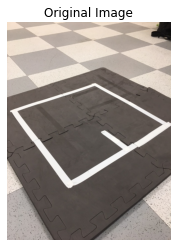

In [61]:
# Load original image
img = cv2.imread('test-images/simple-maze.jpg')
plot_image(img, 'Original Image')

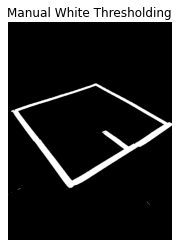

In [62]:
def manual_white_threshold(img):
    '''Selects all white pixels in an image using HSV thresholding'''
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return cv2.inRange(hsv, (0, 0, 215), (180, 15, 255), cv2.THRESH_BINARY)

plot_image(manual_white_threshold(img), 'Manual White Thresholding')

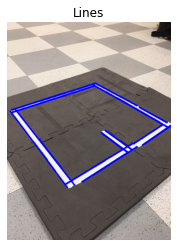

In [63]:
def detect_lines(img: Image) -> List[Line]:
    '''
    Uses a Hough Transform to detect lines in an image. 

    The Hough transform works by
        - Applying edge detection, which returns a list
          of (x, y) pixels that are edges
        - Create a grid of possible lines specified in polar coordinates (p, theta)
        - For each edge pixel (x, y), determine which line it's most likely to contribute
          to and increment the corresponding grid value
        - Threshold the grid to find the most likely lines
    '''
    edges = cv2.Canny(img, 50, 200)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 30, minLineLength=50, maxLineGap=20)
    
    return [Line(*line[0]) for line in lines]

def detect_lines2(img: Image) -> List[Line]:
    '''An alternative line-segment detector (with fewer intersections)'''
    LSD = cv2.createLineSegmentDetector(0)
    return [Line(*map(int, line[0])) for line in LSD.detect(img)[0]]

def draw_lines(img: Image, lines: List[Line], color=(255, 0, 0)) -> Image:
    '''Draws a list of lines on an image'''
    if lines is None or len(lines) == 0:
        return img

    copy = img.copy()

    for line in lines:
        cv2.line(copy, (line.x1, line.y1), (line.x2, line.y2), color, 3)

    return copy

lines = detect_lines(manual_white_threshold(img))
plot_image(draw_lines(img, lines), 'Lines')

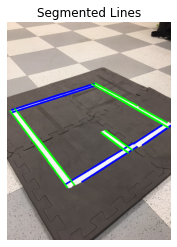

In [64]:
def classify_lines(lines: List[Line]):
    '''Splits the lines into horizontal or vertical'''
    horizontal = []
    vertical = []

    HORIZONTAL_CUTOFF = 0

    for line in lines:
        slope = (line.y1 - line.y2) / (line.x1 - line.x2)

        if slope <= HORIZONTAL_CUTOFF:
            horizontal.append(line)
        else:
            vertical.append(line)

    return horizontal, vertical

def kmeans_classify_lines(lines: List[Line], k=2):
    '''
    Uses K-Means clustering to group lines into horizontal and vertical

    Returns a tuple (horizontal lines, vertical lines)
    '''
    # Grab slopes of each line
    slope_iter = ((line.y1 - line.y2) / (line.x1 - line.x2) for line in lines)
    slopes = np.fromiter(slope_iter, np.float32, count=len(lines))

    # Perform kmeans clustering, stopping if iterations > 10 or the cluster centers move less than epsilon
    stop_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.001)
    _, labels, centers = cv2.kmeans(slopes, k, None, stop_criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Assume the group with the smallest center is horizontal
    horizontal_label = 0 if abs(centers[0]) < abs(centers[1]) else 1
    vertical_label = (horizontal_label + 1) % 2

    labels = labels.ravel() # Flatten labels
    horizontal = [line for i, line in enumerate(lines) if labels[i] == horizontal_label]
    vertical = [line for i, line in enumerate(lines) if labels[i] == vertical_label]

    return horizontal, vertical

horizontal, vertical = classify_lines(lines)
horizontal, vertical = kmeans_classify_lines(lines)

x = draw_lines(img, horizontal, color=(255, 0, 0))
y = draw_lines(x, vertical, color=(0, 255, 0))
plot_image(y, 'Segmented Lines')

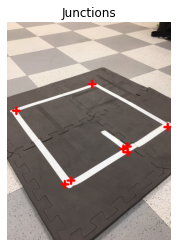

In [65]:
import itertools

EPSILON = 1e-10

def intersection_between(line1: Line, line2: Line) -> Optional[Point]:
    '''
    Find the point of intersection between 2 line segments, if it exists

    For a visual guide of this algorithm, see: https://stackoverflow.com/a/565282
    '''
    l1_dx = line1.x2 - line1.x1
    l1_dy = line1.y2 - line1.y1
    l2_dx = line2.x2 - line2.x1
    l2_dy = line2.y2 - line2.y1 
    
    # Det([l1_dx, l2_dx; l1_dy, l2_dy])
    determinant = (l1_dx * l2_dy - l2_dx * l1_dy)
    
    # Parallel line segments (with zero determinant) have no intersections
    if abs(determinant) < EPSILON:
        return None
    
    # s = distance to the intersection point from the start of line2 as a fraction of segment length
    # t = distance to the intersection point from the start of line1 as a fraction of segment length
    s = (-l1_dy * (line1.x1 - line2.x1) + l1_dx * (line1.y1 - line2.y1)) / determinant
    t = ( l2_dx * (line1.y1 - line2.y1) - l2_dy * (line1.x1 - line2.x1)) / determinant
    
    # If the intersection point lies on both line segments, then we've found a true intersection
    if 0 <= s <= 1 and 0 <= t <= 1:
        x = int(line1.x1 + (t * l1_dx))
        y = int(line1.y1 + (t * l1_dy))

        return Point(x, y)
        
    return None

# Find intersections between all pairs of line segments
copy = img.copy()
intersections = []
for line1, line2 in itertools.combinations(lines, 2):
    # It's walrus time
    if intersection := intersection_between(line1, line2):
        intersections.append(intersection)
        cv2.drawMarker(copy, intersection, (0, 0, 255), thickness=5)
plot_image(copy, 'Junctions')